## <center>RNN Exercises</center>
For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('C:/Users/Lenovo/Desktop/Python/Deep Learning/Data Sets/PyTorch/TimeSeriesData/Energy_Production.csv',
                  index_col=0,parse_dates=True)
df.columns = ["Production"]
df.head()

,Production
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


In [3]:
df.isnull().sum()

Production    0
dtype: int64

**TASK: Plot the data**

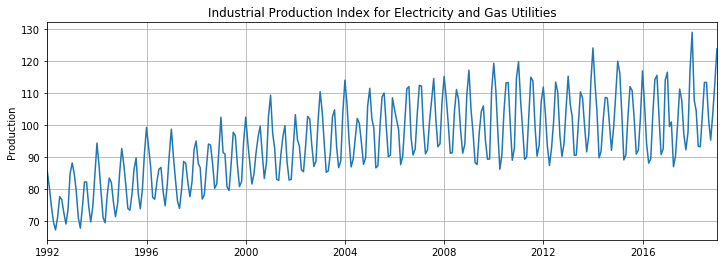

In [4]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Production')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Production'])
plt.show()

**TASK: Divide the data into train and test sets** 

In [5]:
y = df['Production'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [6]:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


**TASK: Normalize the training set**

In [7]:
from sklearn.preprocessing import MinMaxScaler

c:\Users\Lenovo\anaconda3\envs\pytorchenv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [9]:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 85.556
First item, scaled:  [-0.4091274]


**TASK: Prepare data for LSTM**

In [10]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

train_data = input_data(train_norm, window_size)

**TASK: Define the model**

In [11]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

**TASK: Train the model and evaluate**

In [12]:
epochs = 75
future = 12

for i in range(epochs):
    
    model.train()

    # tuple-unpack the train_data set
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
    # MAKE PREDICTIONS
    model.eval()
    preds = train_set[-window_size:].tolist()

    for f in range(future):  
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
        
    
    true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
            


Epoch:  1 Loss: 0.90667009
Epoch:  2 Loss: 0.87880468
Epoch:  3 Loss: 0.82135767
Epoch:  4 Loss: 0.78068143
Epoch:  5 Loss: 0.77625883
Epoch:  6 Loss: 0.77719235
Epoch:  7 Loss: 0.77624875
Epoch:  8 Loss: 0.77513164
Epoch:  9 Loss: 0.77388036
Epoch: 10 Loss: 0.77087045
Epoch: 11 Loss: 0.76341152
Epoch: 12 Loss: 0.75113428
Epoch: 13 Loss: 0.73245156
Epoch: 14 Loss: 0.70873839
Epoch: 15 Loss: 0.68227696
Epoch: 16 Loss: 0.65410978
Epoch: 17 Loss: 0.62460536
Epoch: 18 Loss: 0.59403139
Epoch: 19 Loss: 0.56294370
Epoch: 20 Loss: 0.53229427
Epoch: 21 Loss: 0.50314462
Epoch: 22 Loss: 0.47625670
Epoch: 23 Loss: 0.45186850
Epoch: 24 Loss: 0.42970064
Epoch: 25 Loss: 0.40913677
Epoch: 26 Loss: 0.38950703
Epoch: 27 Loss: 0.37035900
Epoch: 28 Loss: 0.35161152
Epoch: 29 Loss: 0.33352399
Epoch: 30 Loss: 0.31652051
Epoch: 31 Loss: 0.30098441
Epoch: 32 Loss: 0.28713158
Epoch: 33 Loss: 0.27500236
Epoch: 34 Loss: 0.26453635
Epoch: 35 Loss: 0.25559723
Epoch: 36 Loss: 0.24796057
Epoch: 37 Loss: 0.24138018
E

In [13]:
true_predictions

array([[140.11524953],
       [119.1017914 ],
       [ 97.20941133],
       [ 79.44074971],
       [ 86.43066328],
       [106.06676167],
       [118.22373726],
       [115.69642679],
       [107.14761923],
       [104.22655454],
       [109.54890176],
       [115.76477273]])

In [14]:
df[-12:]

,Production
DATE,
2018-02-01,107.6711
2018-03-01,104.5716
2018-04-01,93.4491
2018-05-01,93.2405
2018-06-01,103.3083
2018-07-01,113.3178
2018-08-01,113.2758
2018-09-01,101.5656
2018-10-01,95.3203


**TASK: Plot the result**

In [15]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

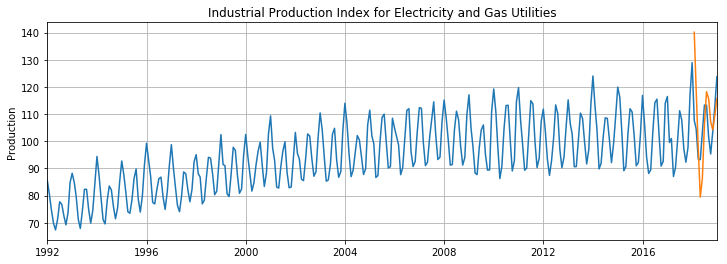

In [16]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Production')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Production'])
plt.plot(x,true_predictions)
plt.show()



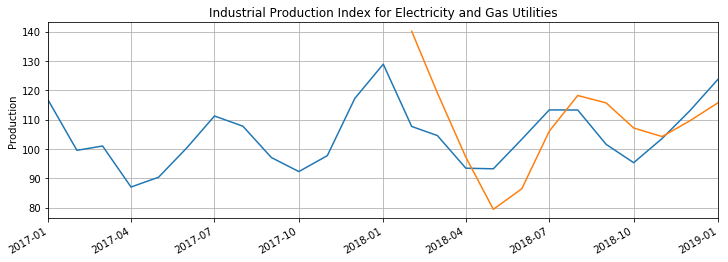

In [17]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Production')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df.loc['2017-01-01':, "Production"])
plt.plot(x,true_predictions)
plt.show()